In [ ]:
!pip install scikit-allel
!pip install --upgrade pip
!pip install autogluon

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path

DATA = Path("/content/drive/My Drive/2021 ECBM E4060/Project/data")

# Importing raw counts (ROSMAP and MSBB)

In [ ]:
import pandas as pd

rosmap = pd.read_csv(DATA / "ROSMAP/ROSMAP_RNAseq_FPKM_gene.tsv", sep="\t")

rosmap.head()

,tracking_id,gene_id,525_120515_0,383_120503_0,93_120417_0,610_120523_0,560_120517_0,492_120515_0,576_120521_0,150_120419_0,416_120503_0,398_120503_0,377_120503_0,583_120522_0,564_120517_1,112_120418_1,574_120521_1,44_120416_1,496_120515_1,526_120515_1,489_120515_1,480_120514_1,470_120514_1,188_120424_1,681_120604_1,522_120515_1,477_120514_1,286_120430_1,488_120515_1,563_120517_1,567_120521_1,363_120502_1,396_120503_1,509_120515_1,593_120522_1,162_120423_1,164_120423_1,458_120507_1,26_120411_1,536_120516_1,...,813_130702_8,951_131107_8,821_130725_8,805_130701_8,925_131031_8,768_130523_8,924_131031_8,929_131031_8,803_130701_8,892_130923_8,936_131101_8,937_131101_8,957_131107_8,887_130923_8,926_131031_8,776_130528_8,826_130725_8,800_130701_8,834_130729_8,889_130923_8,879_130918_8,946_131107_8,861_130911_8,950_131107_8,952_131107_8,935_131101_8,810_130702_8,777_130528_8,941_131101_8,787_130530_8,831_130725_8,901_131010_8,894_130923_8,938_131101_8,942_131101_8,939_131101_8,895_130923_8,829_130725_8,944_131107_8,775_130528_8
0,ENSG00000167578.11,ENSG00000167578.11,60.84,65.45,69.18,51.60,48.61,55.65,51.18,60.63,62.38,47.23,63.00,55.58,68.80,59.53,78.82,83.97,73.71,81.03,54.36,67.73,61.05,69.42,63.73,56.51,64.55,65.71,72.83,68.84,78.51,68.22,73.69,64.44,82.85,57.55,72.01,57.06,60.92,60.43,...,31.90,42.16,34.03,38.31,39.71,46.86,45.44,21.97,34.11,39.32,36.07,30.87,48.77,34.22,42.44,30.96,39.88,40.51,41.23,39.38,27.70,38.27,32.04,39.05,30.84,42.45,34.18,35.76,29.71,36.78,44.85,45.02,33.71,38.30,28.27,51.02,31.87,37.14,41.77,44.01
1,ENSG00000242268.1,ENSG00000242268.1,0.08,0.05,0.08,0.08,0.10,0.08,0.06,0.11,0.05,0.03,0.08,0.14,0.21,0.14,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.06,0.20,0.00,0.07,0.13,0.00,0.15,0.00,0.07,0.00,0.23,0.30,0.15,0.00,0.00,0.13,0.43,...,0.09,0.11,0.20,0.11,0.00,0.00,0.00,0.00,0.19,0.10,0.10,0.07,0.20,0.19,0.00,0.08,0.17,0.16,0.00,0.21,0.00,0.32,0.21,0.00,0.10,0.00,0.08,0.08,0.12,0.09,0.00,0.10,0.20,0.00,0.00,0.00,0.00,0.00,0.09,0.10
2,ENSG00000078237.4,ENSG00000078237.4,4.39,4.49,2.51,2.90,2.67,5.50,3.36,3.43,2.72,2.65,4.78,3.77,3.07,4.69,3.74,2.72,3.01,2.37,4.16,4.47,4.99,3.78,5.18,5.26,4.92,3.88,3.15,4.64,3.51,3.00,4.99,2.72,3.86,5.86,4.00,3.10,2.01,3.40,...,5.71,6.81,3.31,6.42,7.98,4.04,5.64,2.47,2.47,5.33,4.10,5.47,5.08,5.05,3.64,5.00,5.64,5.46,3.59,4.04,6.72,4.42,7.55,5.75,6.55,4.59,3.49,6.53,5.86,6.58,8.15,4.05,6.06,6.03,4.34,5.16,2.70,5.00,3.82,3.69
3,ENSG00000263642.1,ENSG00000263642.1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,ENSG00000225275.4,ENSG00000225275.4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
DATA_MSBB = DATA / "MSBB"

#msbb frontal pole data
msbb_fp = pd.read_csv(DATA_MSBB / "AMP-AD_MSBB_MSSM_BM_10.raw_counts.tsv", sep="\t")

#msbb superior temporal gyrus data
msbb_stg = pd.read_csv(DATA_MSBB / "AMP-AD_MSBB_MSSM_BM_22.raw_counts.tsv", sep="\t")

#msbb parahippocampal gyrus data
#msbb_phg = pd.read_csv(DATA_MSBB / "AMP-AD_MSBB_MSSM_BM_36.raw_counts.tsv", sep="\t")
msbb_phg = pd.read_csv(DATA_MSBB / "msbb_phg_reduced_raw_count.txt", sep="\t")

#msbb inferior frontal gyrus data
msbb_ifg = pd.read_csv(DATA_MSBB / "AMP-AD_MSBB_MSSM_BM_44.raw_counts.tsv", sep="\t")

arr = [msbb_fp.shape, msbb_stg.shape, msbb_phg.shape, msbb_ifg.shape]
arr

[(56632, 262), (56632, 241), (17349, 215), (56632, 223)]

In [ ]:
msbb_phg.head()

,BM_36_428,BM_36_517,BM_36_344,BM_36_308,BM_36_429,hB_RNA_10502,hB_RNA_10617,BM_36_516,BM_36_1107,BM_36_518,BM_36_525,BM_36_545,BM_36_430,BM_36_412,BM_36_416,BM_36_398,BM_36_411,BM_36_413,hB_RNA_10552,BM_36_403,hB_RNA_10372,BM_36_414,BM_36_389,hB_RNA_10583,BM_36_361,BM_36_415,BM_36_397,BM_36_399,BM_36_531,hB_RNA_10822,BM_36_395,hB_RNA_10482,hB_RNA_10622,BM_36_464,hB_RNA_11042,BM_36_400,BM_36_405,BM_36_458,BM_36_448,BM_36_520,...,BM_36_372,BM_36_507,BM_36_348,BM_36_537,BM_36_347,BM_36_384,hB_RNA_10567,hB_RNA_10642,BM_36_534,BM_36_495,BM_36_328,hB_RNA_10672,BM_36_502,BM_36_533,BM_36_387,BM_36_472,BM_36_544,hB_RNA_10542,BM_36_296,BM_36_539,BM_36_425,BM_36_382,BM_36_509,BM_36_435,BM_36_371,BM_36_491,BM_36_329,BM_36_483,BM_36_455,BM_36_305,BM_36_432,BM_36_485,BM_36_466,hB_RNA_10492,BM_36_341,BM_36_467,BM_36_515,hB_RNA_10632,BM_36_327,BM_36_417
ENSG00000211459,1365,2633,505,360,1857,4239,3043,2952,1932,1500,3173,2377,732,537,608,597,317,647,1516,672,10485,506,1302,2041,544,1142,1241,364,2862,3344,457,4527,1742,2252,5218,334,432,1924,1487,1330,...,773,1342,392,2510,484,541,3186,1890,2673,2131,263,816,1181,2296,399,2152,3204,4702,627,3842,623,697,1385,3409,1520,2599,617,2296,2118,472,918,3046,1151,4232,944,1502,1785,1685,288,642
ENSG00000210082,7901,23049,1462,1543,12602,13378,6638,23259,10603,15927,18862,11309,4673,1546,1812,1832,1246,1697,3477,1967,14377,1467,4741,3577,1543,3022,3371,1605,21732,5840,1280,11873,3002,28368,10079,1776,1699,25010,15453,18657,...,2573,12363,2000,18194,1621,2345,7439,4920,23957,19451,902,2142,8644,19027,1656,28681,16060,13557,2335,20861,1929,2347,8034,33370,3220,19141,2097,19802,32695,1911,6042,36908,11471,9726,2959,22618,12120,3951,1503,1821
ENSG00000198888,2800,3626,678,1027,5540,4529,1126,7457,3685,3301,5962,3541,3404,967,535,881,691,765,1813,1068,2413,850,1662,2281,867,1203,1024,1014,7978,1626,762,2228,1851,6002,3527,1291,1768,6085,3163,3287,...,1137,2051,704,2615,794,1445,2592,1514,10171,3209,334,1365,2903,5179,1235,3834,6232,3083,1200,5685,1063,1869,3220,4060,1914,4325,736,4305,4710,646,2771,6191,3178,2187,1143,5349,2822,1503,567,999
ENSG00000198763,2648,4201,834,1044,4554,4761,1090,6793,2800,3407,5348,3350,3840,1185,956,767,723,976,1195,1301,1927,1069,1796,2130,903,1483,1027,983,6316,1371,908,2355,1696,5250,2866,1033,1747,4842,3339,3436,...,1203,1554,907,2759,869,1426,2017,1149,7364,2633,412,1088,2345,3810,1205,3483,4559,3854,1185,5752,1365,1851,3248,3863,1665,3897,852,4123,4452,760,2727,5514,2684,2201,1224,4306,2898,1155,651,1367
ENSG00000198804,98668,113929,8323,28878,110792,123255,38035,144692,93153,65806,123627,91705,96307,12319,10843,17671,13227,11220,59251,22596,110181,14827,34632,65674,15386,24751,18281,25012,162499,55257,13769,84270,83971,167448,99926,24664,29882,88823,111100,80521,...,22371,57289,16981,88112,13806,24627,91127,50831,127059,105222,6397,35373,61424,109464,28766,102594,157147,93901,25107,162309,23664,24108,65784,127950,56877,61023,13970,97910,116160,10612,72520,122031,103597,73776,20106,141512,83936,50696,18307,20711


# Importing and Merging metadata files (ROSMAP and MSBB)

In [ ]:
msbb_metadata = pd.read_csv(DATA_MSBB / "MSBB_individual_metadata.csv")
msbb_biospecimen = pd.read_csv(DATA_MSBB / "MSBB_biospecimen_metadata.csv")

msbb_biospecimen = msbb_biospecimen[~(msbb_biospecimen.individualID == "Unknown")]

msbb_metadata.head()

,individualID,individualIdSource,species,sex,race,ethnicity,yearsEducation,ageDeath,causeDeath,mannerDeath,apoeGenotype,pmi,pH,brainWeight,diagnosis,diagnosisCriteria,CERAD,Braak,CDR,plaqueMean
0,AMPAD_MSSM_0000048992,MSSM,Human,male,W,W,NaN,74.0,NaN,NaN,33.0,255,NaN,NaN,NaN,NaN,2,6,4.0,23.32
1,AMPAD_MSSM_0000023152,MSSM,Human,male,W,W,NaN,71.0,NaN,NaN,NaN,547,NaN,NaN,NaN,NaN,2,6,5.0,23.36
2,AMPAD_MSSM_0000010233,MSSM,Human,male,W,W,NaN,80.0,NaN,NaN,33.0,920,NaN,NaN,NaN,NaN,2,5,3.0,NaN
3,AMPAD_MSSM_0000045634,MSSM,Human,male,W,W,NaN,78.0,NaN,NaN,NaN,345,NaN,NaN,NaN,NaN,2,6,5.0,NaN
4,AMPAD_MSSM_0000032714,MSSM,Human,female,W,W,NaN,90+,NaN,NaN,NaN,835,NaN,NaN,NaN,NaN,2,3,2.0,14.00


It is necessary to merge biospecimen and meta for every brain region seperately, as there is an overlap of specimen IDs.

In [ ]:
msbb_biospecimen_fp = msbb_biospecimen[msbb_biospecimen.tissue == "frontal pole"]
msbb_biospecimen_stg = msbb_biospecimen[msbb_biospecimen.tissue == "superior temporal gyrus"]
msbb_biospecimen_phg = msbb_biospecimen[msbb_biospecimen.tissue == "parahippocampal gyrus"]
msbb_biospecimen_ifg = msbb_biospecimen[msbb_biospecimen.tissue == "inferior frontal gyrus"]

msbb_meta_fp = pd.merge(msbb_biospecimen_fp, msbb_metadata, left_on="individualID", right_on="individualID")
msbb_meta_stg = pd.merge(msbb_biospecimen_stg, msbb_metadata, left_on="individualID", right_on="individualID")
msbb_meta_phg = pd.merge(msbb_biospecimen_phg, msbb_metadata, left_on="individualID", right_on="individualID")
msbb_meta_ifg = pd.merge(msbb_biospecimen_ifg, msbb_metadata, left_on="individualID", right_on="individualID")

[msbb_meta_fp.shape, msbb_meta_stg.shape, msbb_meta_phg.shape, msbb_meta_ifg.shape]

[(388, 37), (935, 37), (987, 37), (301, 37)]

In [ ]:
phg_columns = msbb_phg.columns
stg_columns = msbb_stg.columns
ifg_columns = msbb_ifg.columns
fp_columns = msbb_fp.columns

common_specimens_phg = set(msbb_biospecimen_phg.specimenID) & set(phg_columns)
common_specimens_stg = set(msbb_biospecimen_stg.specimenID) & set(stg_columns)
common_specimens_ifg = set(msbb_biospecimen_ifg.specimenID) & set(ifg_columns)
common_specimens_fp = set(msbb_biospecimen_fp.specimenID) & set(fp_columns)

msbb_biospecimen_phg = msbb_biospecimen_phg[msbb_biospecimen_phg.specimenID.isin(common_specimens_phg)]
msbb_biospecimen_stg = msbb_biospecimen_stg[msbb_biospecimen_stg.specimenID.isin(common_specimens_stg)]
msbb_biospecimen_ifg = msbb_biospecimen_ifg[msbb_biospecimen_ifg.specimenID.isin(common_specimens_ifg)]
msbb_biospecimen_fp = msbb_biospecimen_fp[msbb_biospecimen_fp.specimenID.isin(common_specimens_fp)]

msbb_phg_t = msbb_phg.transpose()
msbb_merged_phg = pd.merge(msbb_biospecimen_phg, msbb_phg_t, left_on="specimenID", right_index=True)
msbb_stg_t = msbb_stg.transpose()
msbb_merged_stg = pd.merge(msbb_biospecimen_stg, msbb_stg_t, left_on="specimenID", right_index=True)
msbb_ifg_t = msbb_ifg.transpose()
msbb_merged_ifg = pd.merge(msbb_biospecimen_ifg, msbb_ifg_t, left_on="specimenID", right_index=True)
msbb_fp_t = msbb_fp.transpose()
msbb_merged_fp = pd.merge(msbb_biospecimen_fp, msbb_fp_t, left_on="specimenID", right_index=True)
[msbb_merged_phg.shape,msbb_merged_stg.shape,msbb_merged_ifg.shape,msbb_merged_fp.shape]

[(214, 17367), (240, 56650), (222, 56650), (261, 56650)]

# Importing training data

The training data is the output of our R program "Project_Clustering.Rmd".

In [ ]:
training_filename = "msbb_phg_clusters.csv"

msbb_phg_clusters = pd.read_csv(DATA_MSBB / training_filename)

msbb_phg_clusters.set_axis(["specimenID", "cluster"], axis=1, inplace=True)

msbb_phg_clusters.head()

,specimenID,cluster
0,BM_36_1107,1
1,BM_36_278,1
2,BM_36_279,1
3,BM_36_281,1
4,BM_36_284,2


In [ ]:
msbb_merged_phg.shape

(214, 17367)

In [ ]:
common_training = set(msbb_merged_phg.specimenID) & set(msbb_phg_clusters.specimenID)

training_data = msbb_merged_phg[msbb_merged_phg.specimenID.isin(common_training)]

#training_data = pd.merge(training_data, msbb_phg_clusters, on="specimenID")

training_data.head()

,individualID,specimenID,specimenIdSource,organ,tissue,BrodmannArea,sampleStatus,tissueWeight,tissueVolume,nucleicAcidSource,cellType,fastingState,assay,isPostMortem,samplingAge,visitNumber,exclude,excludeReason,ENSG00000211459,ENSG00000210082,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,ENSG00000198899,ENSG00000198938,ENSG00000198840,ENSG00000212907,ENSG00000198886,ENSG00000198786,ENSG00000198695,ENSG00000198727,ENSG00000210196,ENSG00000177951,ENSG00000177963,ENSG00000142082,ENSG00000185627,ENSG00000142102,ENSG00000185201,...,ENSG00000197451,ENSG00000175309,ENSG00000050767,ENSG00000113240,ENSG00000169131,ENSG00000178338,ENSG00000198939,ENSG00000178187,ENSG00000113262,ENSG00000234284,ENSG00000177932,ENSG00000087116,ENSG00000176783,ENSG00000249140,ENSG00000169045,ENSG00000127022,ENSG00000161021,ENSG00000161013,ENSG00000161011,ENSG00000161010,ENSG00000197226,ENSG00000113269,ENSG00000249412,ENSG00000146090,ENSG00000050748,ENSG00000253908,ENSG00000131459,ENSG00000113300,ENSG00000037280,ENSG00000131446,ENSG00000245060,ENSG00000196670,ENSG00000165810,ENSG00000146054,ENSG00000146063,ENSG00000204628,ENSG00000233937,ENSG00000183718,ENSG00000268397,ENSG00000248275
527,AMPAD_MSSM_0000056537,BM_36_278,NaN,brain,parahippocampal gyrus,36.0,NaN,NaN,NaN,NaN,NaN,NaN,rnaSeq,True,NaN,NaN,False,NaN,319,1982,1293,1074,25828,3242,56,935,10958,500,302,2102,3242,255,2681,156,137,699,340,646,63,10,...,145,299,67,691,154,240,128,104,47,98,169,30,341,37,1546,5540,447,421,1067,347,2078,1110,18,76,2527,32,249,721,21,484,185,392,125,30,363,1669,8,107,93,38
528,AMPAD_MSSM_0000056019,BM_36_279,NaN,brain,parahippocampal gyrus,36.0,NaN,NaN,NaN,NaN,NaN,NaN,rnaSeq,True,NaN,NaN,False,NaN,473,3017,2274,1912,52356,6148,58,1660,16711,990,535,3420,5731,521,4639,287,248,1186,616,763,124,36,...,280,625,163,881,243,358,155,172,87,149,291,250,604,52,2671,7480,802,712,1758,685,3915,1844,26,141,3577,47,438,1047,57,982,334,696,204,81,727,2627,37,220,180,52
529,AMPAD_MSSM_0000020701,BM_36_281,NaN,brain,parahippocampal gyrus,36.0,NaN,NaN,NaN,NaN,NaN,NaN,rnaSeq,True,NaN,NaN,False,NaN,376,3057,1935,1696,35477,4505,56,1438,17827,730,406,3057,4793,367,3970,266,206,723,331,724,34,20,...,169,409,91,1146,197,321,215,139,46,120,233,39,423,40,1893,7381,422,432,1246,399,2075,999,18,93,3360,43,282,846,11,431,188,504,67,48,395,2123,28,119,111,37
531,AMPAD_MSSM_0000070412,BM_36_284,NaN,brain,parahippocampal gyrus,36.0,NaN,NaN,NaN,NaN,NaN,NaN,rnaSeq,True,NaN,NaN,False,NaN,249,919,380,368,8154,871,32,332,3605,128,109,701,957,159,816,58,58,313,108,353,41,11,...,96,134,27,503,79,135,73,39,7,58,129,15,160,6,1196,4842,130,94,638,156,689,688,8,14,1267,6,169,366,13,212,90,214,16,9,151,1230,10,48,32,18
533,AMPAD_MSSM_0000070216,BM_36_289,NaN,brain,parahippocampal gyrus,36.0,NaN,NaN,NaN,NaN,NaN,NaN,rnaSeq,True,NaN,NaN,False,NaN,707,3166,992,944,41700,3420,40,1328,18739,928,321,2157,3014,534,2997,213,140,409,188,362,91,63,...,143,528,43,839,142,400,153,107,47,123,279,35,373,25,2464,5885,591,326,930,361,1969,1140,14,56,861,33,295,825,30,534,152,506,98,31,393,2011,22,137,116,32


# Reduce MSBB PHG genes to the significant ones for each cluster

In [ ]:
qvalue_filename = "qvalue.txt"

qvalue = pd.read_csv(DATA_MSBB / qvalue_filename, sep=" ")

cols = [c for c in qvalue.columns if c.lower()[:6] == 'qvalue']

qvalue = qvalue[cols]

qvalue["gene"] = msbb_phg.index.values

qvalue.set_index("gene", inplace=True)

qvalue.head()

,qvalue.control...cluster1,qvalue.control...cluster2,qvalue.control...cluster3
gene,,,
ENSG00000211459,0.614675,0.111926,0.163362
ENSG00000210082,0.638757,0.546681,0.116975
ENSG00000198888,0.652696,0.362138,0.149705
ENSG00000198763,0.670839,0.442747,0.158665
ENSG00000198804,0.630027,0.105330,0.168601


selecting significance value for each cluster so there are approximately equally many significant genes for each cluster present.

In [ ]:
col1 = [c for c in qvalue.columns if c.lower()[-8:] == 'cluster1']
qvalue1 = qvalue[col1]
qvalue1 = qvalue1.loc[qvalue1.iloc[:, 0]<0.05]


col2 = [c for c in qvalue.columns if c.lower()[-8:] == 'cluster2']
qvalue2 = qvalue[col2]
qvalue2 = qvalue2.loc[qvalue2.iloc[:, 0]<0.028]


col3 = [c for c in qvalue.columns if c.lower()[-8:] == 'cluster3']
qvalue3 = qvalue[col3]
qvalue3 = qvalue3.loc[qvalue3.iloc[:, 0]<0.0008]

print([qvalue1.shape, qvalue2.shape, qvalue3.shape])

[(76, 1), (113, 1), (103, 1)]


In [ ]:
all_phg = msbb_phg.loc[:, msbb_phg.columns.isin(common_training)]
all_phg = all_phg.transpose()
all_phg.rename_axis("specimenID", axis = 0, inplace=True)

In [ ]:
keep_genes = set(qvalue1.index.values) | set(qvalue2.index.values) | set(qvalue3.index.values)
reduced_genes = all_phg.loc[:, keep_genes]
reduced_genes.head()

,ENSG00000158186,ENSG00000135766,ENSG00000179943,ENSG00000171603,ENSG00000269190,ENSG00000111652,ENSG00000165985,ENSG00000146858,ENSG00000143384,ENSG00000179115,ENSG00000167306,ENSG00000079215,ENSG00000132589,ENSG00000188042,ENSG00000170275,ENSG00000134313,ENSG00000116688,ENSG00000138629,ENSG00000137501,ENSG00000196943,ENSG00000144035,ENSG00000146701,ENSG00000197608,ENSG00000130522,ENSG00000102387,ENSG00000177374,ENSG00000138594,ENSG00000187984,ENSG00000167770,ENSG00000102103,ENSG00000166197,ENSG00000178773,ENSG00000164938,ENSG00000214944,ENSG00000160752,ENSG00000152315,ENSG00000084234,ENSG00000169083,ENSG00000187122,ENSG00000115652,...,ENSG00000164236,ENSG00000217801,ENSG00000162433,ENSG00000177807,ENSG00000113805,ENSG00000197837,ENSG00000106610,ENSG00000174231,ENSG00000187098,ENSG00000064652,ENSG00000177192,ENSG00000101452,ENSG00000127824,ENSG00000185340,ENSG00000196872,ENSG00000115216,ENSG00000103415,ENSG00000199916,ENSG00000162407,ENSG00000264247,ENSG00000181789,ENSG00000229657,ENSG00000187730,ENSG00000124702,ENSG00000170291,ENSG00000137312,ENSG00000062485,ENSG00000126247,ENSG00000110107,ENSG00000188070,ENSG00000148175,ENSG00000268230,ENSG00000074590,ENSG00000176956,ENSG00000078725,ENSG00000067113,ENSG00000181588,ENSG00000267575,ENSG00000162188,ENSG00000135587
specimenID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BM_36_517,3972,2425,230,12054,150,1202,1943,48,2245,806,407,20515,1300,1166,818,11039,3417,705,2572,591,32,1681,577,1474,46,54,792,178,1415,361,1944,334,385,1066,279,55,9052,190,88,671,...,177,74,1940,2732,1472,290,310,5794,338,370,188,382,2247,567,1629,1104,1292,23262,2999,315,2259,60,757,2922,313,2098,1880,1336,2139,648,2240,30,4070,1423,1725,521,135,220,249,88
BM_36_308,2189,1288,79,6814,105,547,725,46,1504,308,251,16099,488,301,526,5503,1732,237,3940,225,42,737,648,542,26,13,457,189,461,88,755,236,347,864,156,29,3851,88,76,354,...,128,28,866,1158,1261,124,145,2985,177,182,146,314,451,186,1132,678,497,14070,2339,264,1044,46,293,1276,140,719,810,412,987,394,1785,9,1803,1011,913,211,62,238,51,61
hB_RNA_10502,1704,962,106,3900,65,386,435,29,1258,223,79,11995,388,313,623,3417,1114,163,4071,178,19,518,339,654,22,24,456,189,315,97,567,181,204,374,96,18,2783,39,98,290,...,93,43,1048,1837,734,58,79,1746,103,131,74,114,416,281,795,308,272,6366,1924,144,545,34,182,743,121,613,756,373,521,371,1347,22,1236,431,580,241,89,143,48,29
hB_RNA_10617,3593,1770,161,6021,125,576,585,29,2076,397,122,12636,728,490,975,4267,2010,392,2119,351,12,901,276,1150,27,65,486,101,583,216,912,201,298,497,162,43,4466,110,87,447,...,125,42,1113,2113,762,118,94,3229,242,168,96,183,850,553,1033,507,508,14006,2589,191,1038,59,237,1482,254,1281,909,785,990,531,2233,22,1482,980,919,426,129,107,88,65
BM_36_516,2525,1258,130,6938,128,697,762,66,1303,480,168,12886,772,540,522,7075,2104,359,4588,326,57,1006,608,1018,44,27,357,306,751,227,927,383,256,901,170,39,4345,76,129,446,...,183,85,1283,1613,1283,151,163,3394,179,188,214,335,921,486,1309,566,587,17339,3131,263,1117,72,356,1601,182,1079,1022,693,1244,470,1385,35,1742,1001,920,287,117,280,157,59


In [ ]:
msbb_phg_clusters = msbb_phg_clusters.set_index("specimenID")
msbb_phg_clusters

,cluster
specimenID,
BM_36_1107,1
BM_36_278,1
BM_36_279,1
BM_36_281,1
BM_36_284,2
...,...
hB_RNA_11052,1
hB_RNA_11132,1
hB_RNA_11142,1


# Prepare data for Machine Learning

First take 20% of randomly selected data from msbb_phg as test data.

In [ ]:
#all_phg = msbb_phg.set_index("Ensembl ID")
#all_phg = msbb_phg.loc[:, msbb_phg.columns.isin(common_training)]
#all_phg = all_phg.transpose()
#all_phg.rename_axis("specimenID", axis = 0, inplace=True)
x_test = reduced_genes.sample(frac = 0.2)
x_train = reduced_genes[~(reduced_genes.index.isin(set(x_test.index)))]
[reduced_genes.shape, x_test.shape, x_train.shape]

[(150, 284), (30, 284), (120, 284)]

In [ ]:
y_train = msbb_phg_clusters
y_test = y_train[y_train.index.isin(set(x_test.index))]
y_train = y_train[y_train.index.isin(set(x_train.index))]
[msbb_phg_clusters.shape, y_test.shape, y_train.shape]

[(150, 1), (30, 1), (120, 1)]

In [ ]:
from sklearn.feature_selection import mutual_info_classif

midf = pd.DataFrame({
    "feature": x_train.columns,
    "mi": mutual_info_classif(x_train, y_train)
}).sort_values("mi", ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


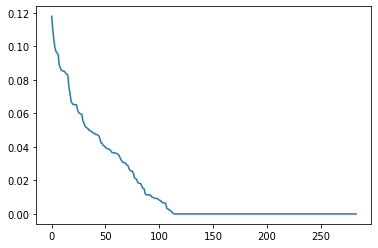

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(284), midf.mi.iloc[:284])

In [ ]:
selected_genes = midf.loc[midf.mi >= 0.005, "feature"]
len(selected_genes)

107

In [ ]:
from autogluon.tabular import TabularPredictor
train_data = x_train.copy().loc[:, selected_genes].copy()
train_data["cluster"] = y_train.values

predictor = TabularPredictor(label="cluster", path="good_quality_cluster").fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
)

Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "good_quality_cluster/"
AutoGluon Version:  0.3.1
Train Data Rows:    120
Train Data Columns: 284
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [1, 3, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7193.11 MB
	Train Data (Original)  Memory Usage: 0.27 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Gen

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0                CatBoost_BAG_L1   0.600000       0.037702  23.495608                0.037702          23.495608            1      False          6
1            WeightedEnsemble_L2   0.600000       0.038233  23.789553                0.000531           0.293945            2      False         11
2              LightGBMXT_BAG_L1   0.558333       0.023321   1.432673                0.023321           1.432673            1      False          2
3           LightGBMLarge_BAG_L1   0.541667       0.025970   5.933805                0.025970           5.933805            1      False         10
4                LightGBM_BAG_L1   0.533333       0.020676   1.684660                0.020676           1.684660            1      False          3
5                 XGBoost_BAG_L1   0.525000       

{'leaderboard':                            model  score_val  ...  can_infer  fit_order
 0                CatBoost_BAG_L1   0.600000  ...      False          6
 1            WeightedEnsemble_L2   0.600000  ...      False         11
 2              LightGBMXT_BAG_L1   0.558333  ...      False          2
 3           LightGBMLarge_BAG_L1   0.541667  ...      False         10
 4                LightGBM_BAG_L1   0.533333  ...      False          3
 5                 XGBoost_BAG_L1   0.525000  ...      False          9
 6     ExtraTreesEntr_BAG_L1_FULL   0.508333  ...       True         19
 7          ExtraTreesEntr_BAG_L1   0.508333  ...      False          8
 8         NeuralNetFastAI_BAG_L1   0.500000  ...      False          1
 9        RandomForestGini_BAG_L1   0.466667  ...      False          4
 10  RandomForestGini_BAG_L1_FULL   0.466667  ...       True         15
 11         ExtraTreesGini_BAG_L1   0.458333  ...      False          7
 12    ExtraTreesGini_BAG_L1_FULL   0.458333  ...

In [ ]:
test_data = x_test.loc[:, selected_genes].copy()
y_pred_score = predictor.predict_proba(test_data)
y_pred = predictor.predict(test_data)

In [ ]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):
    # We can find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.argmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_pred_score, average="weighted",
                               multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

In [ ]:
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.5,
 'auroc': 0.5679951690821257,
 'balanced_accuracy': 0.38095238095238093,
 'f1': 0.36296296296296293}